In [1]:
# Model design
import agentpy as ap
import networkx as nx
import numpy as np
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

## Introduction 
This is a very simple world model to explore the tech adoption in a population. I plan to extend this to include additional resources in the future including resources, types of AI, and community resource pooling, however this is just a start.


A logical place to start when modeling technology adoption is Rogers' model of innovation diffusion:



**Diffusion of Innovations (5th Edition)** by Everett M. Rogers
- **Publisher**: Free Press  
- **Year**: 2003 (latest edition)  
- **ISBN**: 978-0743222099  

This book is the definitive work on the subject, presenting the theory and the five stages of the diffusion process:
1. Knowledge
2. Persuasion
3. Decision
4. Implementation
5. Confirmation

Key factors affecting the adoption of innovations include:
- **Innovation attributes**: Relative advantage, compatibility, complexity, trialability, and observability.  
- **Adopter categories**: Innovators, early adopters, early majority, late majority, and laggards.  

The book also includes case studies and practical applications across disciplines, making it a comprehensive resource for understanding how innovations spread in societies.

This model will begin with a simple exploration of the adopter categories and be expanded in future iterations.


## Simple Exploration

Lets start with just 2 attributes of each agent, 1) what their category is and 2) if they have adopted the technology or not.

I will model the category with numpy.model.choice according to a non-uniform distribution

In [2]:
categories = ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'] # tech adoption categories
probabilities = [0.05, 0.1, 0.35, 0.35, 0.15] # fraction of the population that falls into each category
thresholds = [0.0, 0.3, 0.7, 0.8, 0.9] # threshold above which fraction of adopted neighbors will cause agent to adopt

rng = np.random.default_rng()

samples = rng.choice(categories, p=probabilities)
samples

def tech_categorical(categories,probabilities,population_size=100, rng=np.random.default_rng()):
    rng = np.random.default_rng()

    samples = rng.choice(categories, size=population_size,p=probabilities)
    return samples

## Agentpy Agent definition

I will use [Agentpy](https://agentpy.readthedocs.io/en/latest/) as my python based agent modeling framework. 

We will start by defining the attributes and behaviour of the agent or in this case person adopting the tech.

In [3]:
class InnovationAgent(ap.Agent):
    def setup(self):
        """
        Initializes the agent's adoption state and assigns it to a category based on predefined probabilities.
        """
        # Everyone starts as having not adopted the technology
        self.adopted = False

        # Select a category for the agent using the given probabilities
        rng = np.random
        self.category_idx = rng.choice(len(self.p.categories), p=self.p.probabilities)
        self.category = self.p.categories[self.category_idx]

    def num_adopted_neighbors(self):
        """
        Calculates the number of neighboring agents who have adopted the innovation.
        Returns:
            int: The count of neighbors who have adopted.
        """
        # Get the neighbors of the current agent
        neighbors = self.network.neighbors(self)
        
        # Check adoption status for each neighbor
        adopted = [n.adopted for n in neighbors]
        
        # Count the number of adopters
        return sum(adopted)

    def neighbor_adopted_frac(self):
        """
        Calculates the fraction of neighboring agents who have adopted the innovation.
        Returns:
            float: Fraction of neighbors who have adopted, or 0 if there are no neighbors.
        """
        # Get the neighbors of the current agent
        neighbors = self.network.neighbors(self)
        
        # Check adoption status for each neighbor
        adopted = [n.adopted for n in neighbors]
        len_neighbors = len(adopted)

        # Handle case where there are no neighbors
        if len_neighbors == 0:
            return 0

        # Calculate and return the fraction of adopters
        num_adopters = sum(adopted)
        return num_adopters / len_neighbors

    def adopt_innovation(self):
        """
        Determines whether the agent adopts the innovation based on its category
        and the adoption status of its neighbors.
        """
        # Only proceed if the agent has not already adopted the innovation
        if not self.adopted:
            # Innovators adopt unconditionally
            if self.category == 'innovator':
                self.adopted = True
            # Other categories adopt based on a threshold of neighbor adoption
            elif self.category in ['early_adopter', 'early_majority', 'late_majority', 'laggard']:
                # Calculate the fraction of neighbors who have adopted
                adopted_frac = self.neighbor_adopted_frac()

                # Get the threshold for the agent's category
                threshold = self.p.thresholds[self.category_idx]

                # Adopt if the fraction meets or exceeds the threshold
                if adopted_frac >= threshold:
                    self.adopted = True

In [4]:
class InnovationModel(ap.Model):
    """
    This class represents the overall model for innovation diffusion. It manages the setup,
    simulation steps, and final results.
    """

    def setup(self):
        """
        Initializes the network and agents for the simulation. A small-world network is
        created using the Watts-Strogatz model, and agents are assigned to it.
        """
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_connections,
            self.p.network_rewire_probability,
        )

        # Create agents and a network
        self.agents = ap.AgentList(self, self.p.population, InnovationAgent)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)

    def update(self):
        """
        Calculates the fraction of agents who have adopted the innovation and records it.
        Stops the simulation if all agents have adopted.
        """
        frac_adopted = sum(1 for a in self.agents if a.adopted) / self.p.population
        self.record("fraction adopted", frac_adopted)

        # Stop if everyone has adopted the tech
        if frac_adopted == 1:
            self.stop()

    def step(self):
        """
        Executes a single step of the simulation. During each step, agents decide
        whether to adopt the innovation based on their category and network connections.
        """
        for agent in self.agents:
            agent.adopt_innovation() # Agents adopt innovations based on their category and network connections
    
    def end(self):
        """
        Finalizes the simulation. Additional computations or outputs can be added here if needed.
        """
        pass

## Running The Model

Now that we have the agent model and the innovation model, we can perform a simple run using the parameters below.

In [5]:
parameters = {
    'population': 100,
    "categories": ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
    "probabilities": [0.05, 0.1, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.1, 0.25, 0.5, 0.9],
    "number_of_connections": 4,
    "network_rewire_probability": 0.1,
    "steps":100,
}

Completed: 100 steps
Run time: 0:00:00.014400
Simulation finished


Forshadowing a bit, I asked gpt4o to describe this set of parameters in terms of what they represent, and what are the benefits and drawbacks of this model in terms of realism - this is the output:

### **Prompt to 4o**

tell me in words what this configuration means for our ai adoption model


```
parameters = {
    'population': 100,
    "categories": ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
    "probabilities": [0.05, 0.1, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.1, 0.25, 0.5, 0.9],
    "number_of_connections": 4,
    "network_rewire_probability": 0.1,
    "steps":100,
}
```

### **Output**

This configuration outlines the structure and dynamics of an AI adoption model, reflecting how a population adopts AI technology over time. Here's a breakdown of the parameters and their implications:

1. **`population`: 100**  
   - The total number of individuals in the simulation. The model assumes there are 100 entities (people, organizations, etc.) interacting within the network.

2. **`categories`: ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard']**  
   - These are the adoption categories based on the diffusion of innovations theory. Individuals are classified into groups reflecting their likelihood to adopt the AI:
     - **Innovators**: The earliest adopters, willing to take risks.
     - **Early adopters**: Next in line, more cautious but still ahead of the curve.
     - **Early majority**: A large group adopting after initial success is evident.
     - **Late majority**: More skeptical, adopting only after widespread acceptance.
     - **Laggards**: The last to adopt, resistant to change.

3. **`probabilities`: [0.05, 0.1, 0.35, 0.35, 0.15]**  
   - These are the proportions of the population belonging to each category:
     - 5% are innovators.
     - 10% are early adopters.
     - 35% are in the early majority.
     - 35% are in the late majority.
     - 15% are laggards.

4. **`thresholds`: [0.0, 0.1, 0.25, 0.5, 0.9]**  
   - Each category has a specific threshold value that determines how much influence they need from their network to adopt AI:
     - Innovators have no threshold (0.0); they adopt immediately.
     - Early adopters adopt once they see 10% of their connections adopt.
     - Early majority need 25% of their connections to adopt.
     - Late majority need 50% of their connections to adopt.
     - Laggards require 90% of their connections to adopt.

5. **`number_of_connections`: 4**  
   - Each individual in the network connects to 4 others on average. This reflects the local interaction structure, where adoption decisions are influenced by these connections.

6. **`network_rewire_probability`: 0.1**  
   - A 10% chance exists for a connection in the network to rewire randomly. This introduces small-world or random network features, increasing the likelihood of influence spreading more widely across the population.

7. **`steps`: 100**  
   - The simulation runs for 100 steps, representing the time over which adoption spreads.

### Summary of the Model:
This configuration models how a population of 100 individuals, distributed across adoption categories with specific thresholds, interacts in a network to adopt AI. Adoption begins with the innovators and spreads based on network influences and thresholds over 100 time steps. The network's structure (connections and rewiring probability) plays a significant role in determining how quickly adoption propagates.

### **Further Prompt**

how realistic is this configuration for exploring ai technology adoption

### **Response**

This configuration is a reasonable starting point for exploring AI technology adoption but has some limitations and simplifications. Here's an assessment of its realism and how it could be improved for better accuracy:

---

### **Strengths of the Configuration**

1. **Diffusion of Innovation Framework**  
   - The use of categories (innovator, early adopter, etc.) and adoption thresholds is consistent with established theories like Rogers' Diffusion of Innovations, making it a good conceptual foundation.

2. **Population Distribution**  
   - The probabilities (e.g., 5% innovators, 35% early/late majority) align with historical observations of technology adoption curves. These proportions provide a realistic basis for modeling.

3. **Network Effects**  
   - The model includes a network structure and a rewire probability, capturing how social interactions and random connections influence adoption.

4. **Threshold-Based Behavior**  
   - Adoption thresholds for each category realistically mimic the varying levels of influence required to convince individuals to adopt AI.

---

### **Limitations of Realism**

1. **Small Population Size**  
   - A population of 100 is manageable for simulations but may oversimplify real-world dynamics. Larger populations with more complex structures might yield insights closer to real-world scenarios.

2. **Fixed Number of Connections**  
   - A uniform number of 4 connections per individual may not capture the diversity in social or organizational networks. In reality, some entities (e.g., thought leaders or enterprises) are highly connected, while others are isolated.

3. **Static Probabilities and Thresholds**  
   - The thresholds and category probabilities are fixed, but real-world behavior evolves:
     - Thresholds may decrease over time as AI becomes more familiar or trusted.
     - Probabilities might shift due to cultural, economic, or policy changes.

4. **Simplified Network Rewiring**  
   - A 10% rewiring probability adds randomness but doesn't account for structured randomness in real-world networks, such as geographic clustering, industry focus, or social media dynamics.

5. **No Feedback Effects**  
   - The model assumes adoption is influenced only by immediate connections, without accounting for external feedback like marketing, policy interventions, or mass media effects.

6. **Single Technology Assumption**  
   - The model assumes a single AI technology is being adopted uniformly. In reality, different AI solutions (e.g., chatbots, predictive analytics, robotics) will have distinct adoption paths.

7. **No Cost or Risk Considerations**  
   - Adoption decisions often depend on perceived costs, risks, and benefits. This model doesn't account for these factors, which are crucial in AI adoption.

---

### **Suggestions to Improve Realism**

1. **Expand Population Size and Diversity**  
   - Increase the population and introduce heterogeneity in demographics, industries, or geographies to mimic real-world dynamics.

2. **Vary Connection Numbers**  
   - Use a distribution (e.g., power law or exponential) for connections to simulate highly connected hubs and sparsely connected nodes.

3. **Dynamic Thresholds and Probabilities**  
   - Allow thresholds and category probabilities to evolve based on cumulative adoption, external events, or technological improvements.

4. **Introduce Feedback Mechanisms**  
   - Add external drivers like advertising, government incentives, or media influence to simulate broader societal effects on adoption.

5. **Multiple AI Technologies**  
   - Model adoption for several AI technologies, with interactions and dependencies among them.

6. **Incorporate Cost-Benefit Analysis**  
   - Include factors such as costs, risks, and perceived benefits in individual adoption decisions.

7. **Refine Network Structure**  
   - Use real-world-inspired network models (e.g., small-world, scale-free) to better capture how social and organizational networks function.

---

### **Conclusion**
The configuration is a reasonable approximation for studying AI adoption in a controlled, theoretical setting. However, to make the model more realistic and applicable to real-world scenarios, enhancements such as dynamic thresholds, diverse network structures, and feedback effects are recommended.

## Actual Model Run

In [28]:
model = InnovationModel(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:00.011041
Simulation finished


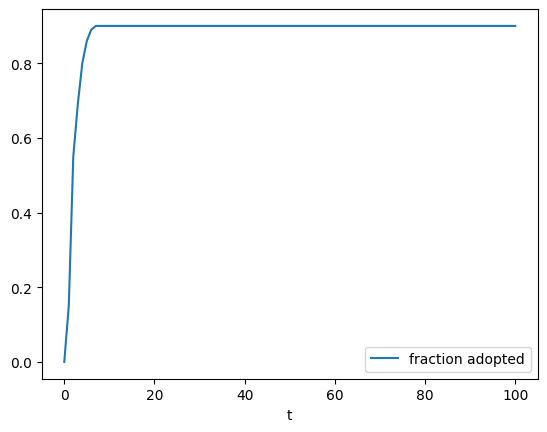

In [29]:
%matplotlib inline
data = results.variables.InnovationModel
ax = data.plot()

### Interpretation

This shows that the fraction of total population adoption increased pretty dramatically and then plateaued at a fairly early epooch at around 89% adoption.

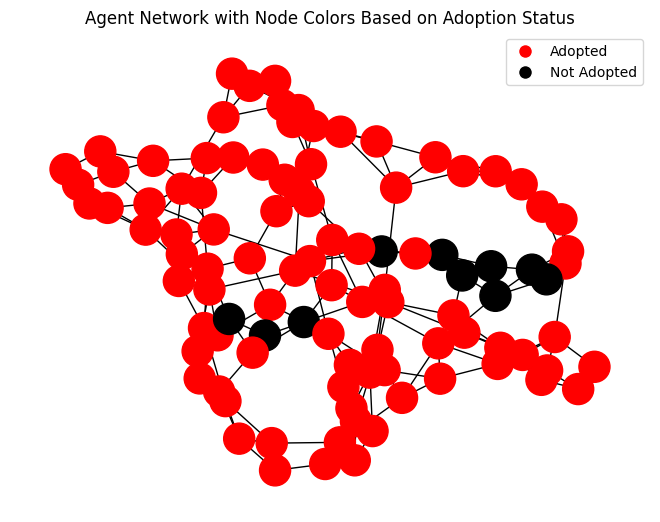

In [30]:
%matplotlib inline  
# Enable interactive widgets for matplotlib (e.g., zooming and panning).

# Get the network and agent data from the model.
network = model.network  # Retrieve the network structure from the model.
adopted_states = [agent.adopted for agent in model.agents]  # Extract the adoption status (True/False) for all agents.

# Define node colors based on the adopted parameter.
# Nodes representing agents with 'adopted = True' will be red, otherwise black.
node_colors = ['red' if adopted else 'black' for adopted in adopted_states]

# Generate labels for nodes based on the agent's category index.
# Each node is labeled with its corresponding agent's category index as a string.
labels = [str(agent.category_idx) for agent in model.agents]
labels = {i: labels[i] for i in range(len(labels))}  # Map labels to node indices for visualization.

# Define the layout of the graph using the spring layout.
pos = nx.spring_layout(network.graph)  # Position nodes using a force-directed layout algorithm.

# Draw the network graph using NetworkX's `draw` method.
nx.draw(
    network.graph,         # The graph to draw.
    pos,                   # Node positions.
    node_color=node_colors,  # Colors of the nodes based on adoption status.
    with_labels=False,     # Whether to show labels on the nodes (currently disabled).
    node_size=500          # Size of the nodes in the graph.
)

# Add a legend to explain node colors.
# The legend will have two entries: one for 'Adopted' (red) and one for 'Not Adopted' (black).
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Adopted', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Not Adopted', markerfacecolor='black', markersize=10)
])

# Add a title to the plot for better understanding.
plt.title("Agent Network with Node Colors Based on Adoption Status")

# Display the graph.
plt.show()
# plt.close()  # Optionally close the plot if running in an interactive environment to avoid clutter.


This plot shows the network at the final state with the nodes that adopted the technology shown in red, and the nodes that did not shown in black. There are clear "islands of Ludites" that have not adopted the technology and wont because of thresholds needed for adoption.

## Playing around with networkx graphing

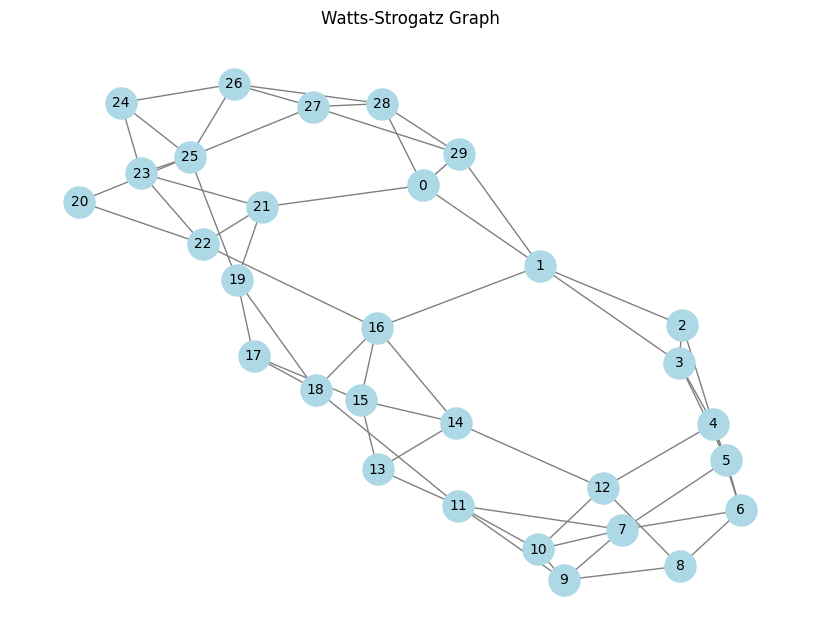

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Parameters for the Watts-Strogatz graph
n = 30  # Number of nodes
k = 4   # Each node is connected to k nearest neighbors in ring topology
p = 0.1 # Probability of rewiring each edge

# Create a Watts-Strogatz small-world graph
G = nx.watts_strogatz_graph(n, k, p)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)

# Show the plot
plt.title("Watts-Strogatz Graph")
plt.show()